<center><h1>Prediction of mutant phenotype</h1></center>

<center><h2>PLSCI 7202</h2></center>
<center><h2>Cornell University</h2></center>

This dataset is obtained from the [following paper](http://www.plantcell.org/content/27/8/2133.short):

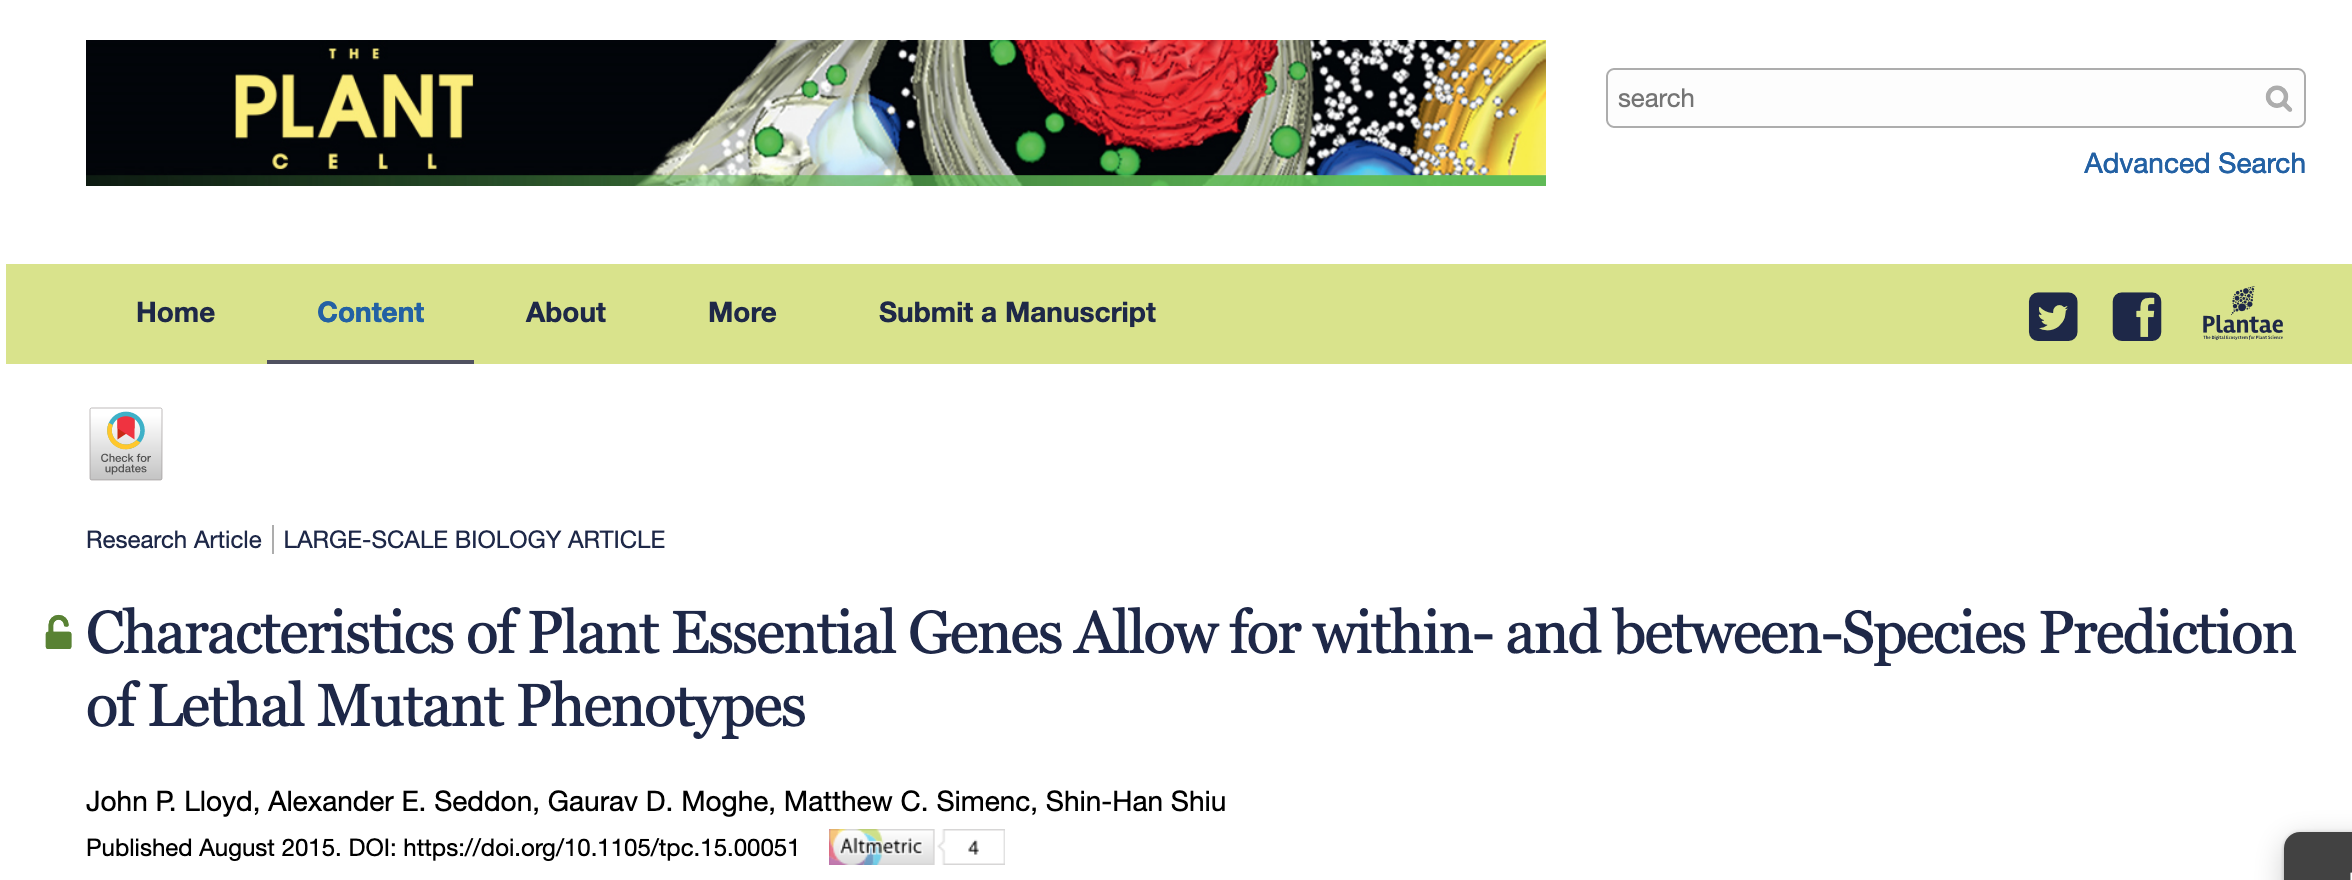

In this paper, authors collected multiple features of genes in Arabidopsis, and using a previously compiled training dataset, generated a random forest model to predict whether knockout mutant of a gene would create a lethal phenotype or not (i.e. whether the gene is essential or not). Abstract of the paper is pasted below:

*Essential genes represent critical cellular components whose disruption results in lethality. Characteristics shared among essential genes have been uncovered in fungal and metazoan model systems. However, features associated with plant essential genes are largely unknown and the full set of essential genes remains to be discovered in any plant species. Here, we show that essential genes in Arabidopsis thaliana have distinct features useful for constructing within- and cross-species prediction models. Essential genes in A. thaliana are often single copy or derived from older duplications, highly and broadly expressed, slow evolving, and highly connected within molecular networks compared with genes with nonlethal mutant phenotypes. These gene features allowed the application of machine learning methods that predicted known lethal genes as well as an additional 1970 likely essential genes without documented phenotypes. Prediction models from A. thaliana could also be applied to predict Oryza sativa and Saccharomyces cerevisiae essential genes. Importantly, successful predictions drew upon many features, while any single feature was not sufficient. Our findings show that essential genes can be distinguished from genes with nonlethal phenotypes using features that are similar across kingdoms and indicate the possibility for translational application of our approach to species without extensive functional genomic and phenomic resources.*

In this exercise, we will work with the dataset the authors compiled and deposited in the Supplementary Files section of the manuscript. As with the previous two exercises, we will perform some EDA, test different models, select the best model, and determine features important for classification. We will perform the ML analysis in PyCaret.

# Data import and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pycaret
import phik

ModuleNotFoundError: No module named 'pycaret'

In [7]:
df=pd.read_csv("arabidopsis_geneFeatures.tab", sep="\t", header=0)
df.head()

,Locus number,Median expression,Ka/Ks - O. sativa,Expression correlation,No. of protein domains,Sequence conservation in Fungi (% ID),AraNet edges,Ka/Ks - V. vinifera,Ka/Ks - A. lyrata,Sequence conservation in Metazoans (% ID),...,Tandem duplicate,No homolog in rice,GOslim C nucleoplasm,GOslim P nucleobase-containing compound metabolic process,GOslim P signal transduction,GOslim F nucleotide binding,GOslim F signal transducer activity,GOslim C plasma membrane,GOslim P response to abiotic stimulus,GOslim P reproduction
0,AT1G01010,20.13853781,?,0.842011343,1,35.625,?,?,0.378464819,31.530,...,0,1,0,0,0,0,0,0,0,0
1,AT1G01020,?,0.34544744,?,1,40.430,6,0.227884443,0.43697479,39.885,...,0,0,0,0,0,0,0,0,0,0
2,AT1G01030,26.16733975,?,0.759791103,1,23.610,?,?,0.142611684,28.570,...,0,0,0,0,0,0,0,0,0,0
3,AT1G01040,182.9879852,?,0.820561894,9,39.455,130,0.099502488,?,44.170,...,0,1,1,1,0,0,0,0,1,1
4,AT1G01050,1093.078484,?,0.528097411,1,38.810,3,?,0,35.775,...,0,0,0,1,0,0,0,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27206 entries, 0 to 27205
Data columns (total 58 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Locus number                                                          27206 non-null  object 
 1   Median expression                                                     27206 non-null  object 
 2   Ka/Ks - O. sativa                                                     27206 non-null  object 
 3   Expression correlation                                                27206 non-null  object 
 4   No. of protein domains                                                27206 non-null  int64  
 5   Sequence conservation in Fungi (% ID)                                 27206 non-null  float64
 6   AraNet edges                                                          27206 non-null  object 


We see that there is a lot of missing data (?). However, Pandas recognizes only specific strings as missing data, and ? is not one of them. We need to first change ? to NaN

In [9]:
df2=df.replace('?', np.NaN)
#df2=pd.to_numeric(df,errors='coerce')
df2.head()
df2.info()

#How do you know we have successfully defined missing data?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27206 entries, 0 to 27205
Data columns (total 58 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Locus number                                                          27206 non-null  object 
 1   Median expression                                                     20397 non-null  object 
 2   Ka/Ks - O. sativa                                                     5339 non-null   object 
 3   Expression correlation                                                15959 non-null  object 
 4   No. of protein domains                                                27206 non-null  int64  
 5   Sequence conservation in Fungi (% ID)                                 27206 non-null  float64
 6   AraNet edges                                                          19268 non-null  object 


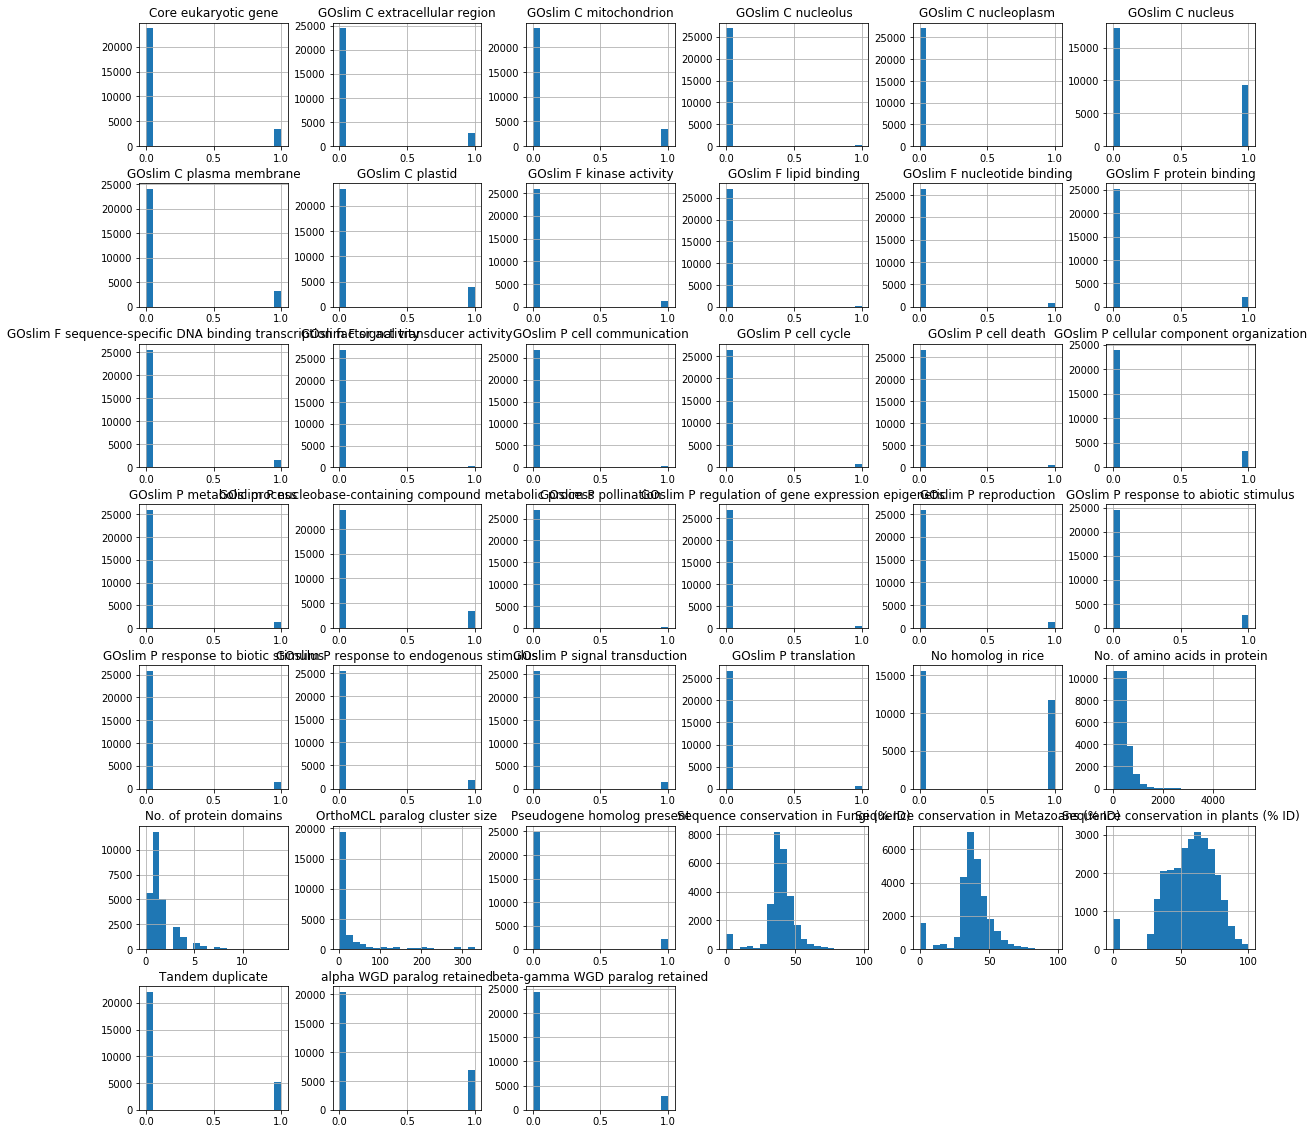

In [10]:
df2.hist(bins=20,figsize=(20,20));

__Exercise 1:__

* What are your thoughts about the data structure?
* Separate out the binary variables from the continuous variables into two different data frames
* Plot pairwise correlations between features within each of the data frames

In [11]:
#Split the data frame into two parts -- binary and continuous variables
part1=df2[df2.columns[24:]]
part1.head()

,Core eukaryotic gene,GOslim P cell communication,GOslim P translation,GOslim F lipid binding,GOslim P cell death,GOslim P cell cycle,Pseudogene homolog present,GOslim P metabolic process,GOslim C mitochondrion,beta-gamma WGD paralog retained,...,Tandem duplicate,No homolog in rice,GOslim C nucleoplasm,GOslim P nucleobase-containing compound metabolic process,GOslim P signal transduction,GOslim F nucleotide binding,GOslim F signal transducer activity,GOslim C plasma membrane,GOslim P response to abiotic stimulus,GOslim P reproduction
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,...,0,1,1,1,0,0,0,0,1,1
4,1,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [11]:
#Get correlations
#c1=part1.corr(method="spearman") #Spearman and Pearsons are not appropriate for binary variables
c1=part1.phik_matrix()
c1.head()

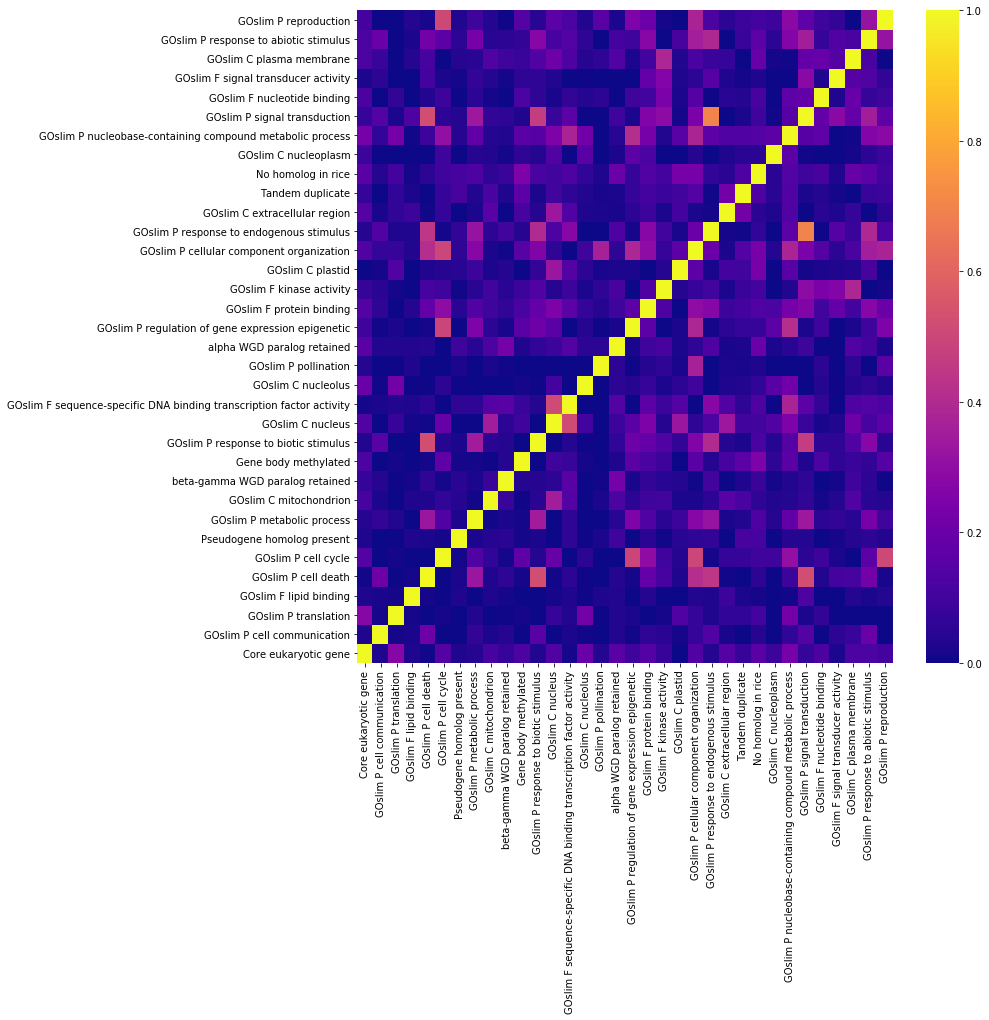

In [14]:
#Visualization using heatmap
plt.figure(figsize=(12,12))
ax = sns.heatmap(c1, cmap="plasma")
ax.invert_yaxis()

In [15]:
#Repeat the same for the continuous values
part2=df2[df2.columns[1:24]]
#part2.head()

#How many columns are there here?

In [16]:
c2=part2.corr(method="spearman")
c2

#Does the correlation matrix look correct? What's wrong?

,No. of protein domains,Sequence conservation in Fungi (% ID),Sequence conservation in Metazoans (% ID),No. of amino acids in protein,Sequence conservation in plants (% ID),OrthoMCL paralog cluster size
No. of protein domains,1.000000,0.316773,0.377254,0.505438,0.316719,0.494092
Sequence conservation in Fungi (% ID),0.316773,1.000000,0.662589,0.003384,0.295915,0.156276
Sequence conservation in Metazoans (% ID),0.377254,0.662589,1.000000,0.121942,0.345566,0.169612
No. of amino acids in protein,0.505438,0.003384,0.121942,1.000000,0.195478,0.295524
Sequence conservation in plants (% ID),0.316719,0.295915,0.345566,0.195478,1.000000,0.020553
OrthoMCL paralog cluster size,0.494092,0.156276,0.169612,0.295524,0.020553,1.000000


In [17]:
#Lets look at the dtypes of the columns that made it vs. those that didn't
part2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27206 entries, 0 to 27205
Data columns (total 23 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Median expression                          20397 non-null  object 
 1   Ka/Ks - O. sativa                          5339 non-null   object 
 2   Expression correlation                     15959 non-null  object 
 3   No. of protein domains                     27206 non-null  int64  
 4   Sequence conservation in Fungi (% ID)      27206 non-null  float64
 5   AraNet edges                               19268 non-null  object 
 6   Ka/Ks - V. vinifera                        15940 non-null  object 
 7   Ka/Ks - A. lyrata                          17180 non-null  object 
 8   Sequence conservation in Metazoans (% ID)  27206 non-null  float64
 9   Ka/Ks - P. trichocarpa                     17807 non-null  object 
 10  Ka/Ks - P. patens     

In [18]:
#Let's convert objects to floats
def convert_dtype(datframe):
    for col in datframe.columns:
        dt=datframe[col].dtypes
        if dt=='object':
            datframe[col]=datframe[col].astype(str).astype(float)
    return datframe
part2 = convert_dtype(part2)
part2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27206 entries, 0 to 27205
Data columns (total 23 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Median expression                          20397 non-null  float64
 1   Ka/Ks - O. sativa                          5339 non-null   float64
 2   Expression correlation                     15959 non-null  float64
 3   No. of protein domains                     27206 non-null  int64  
 4   Sequence conservation in Fungi (% ID)      27206 non-null  float64
 5   AraNet edges                               19268 non-null  float64
 6   Ka/Ks - V. vinifera                        15940 non-null  float64
 7   Ka/Ks - A. lyrata                          17180 non-null  float64
 8   Sequence conservation in Metazoans (% ID)  27206 non-null  float64
 9   Ka/Ks - P. trichocarpa                     17807 non-null  float64
 10  Ka/Ks - P. patens     

/Users/gauravmoghe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


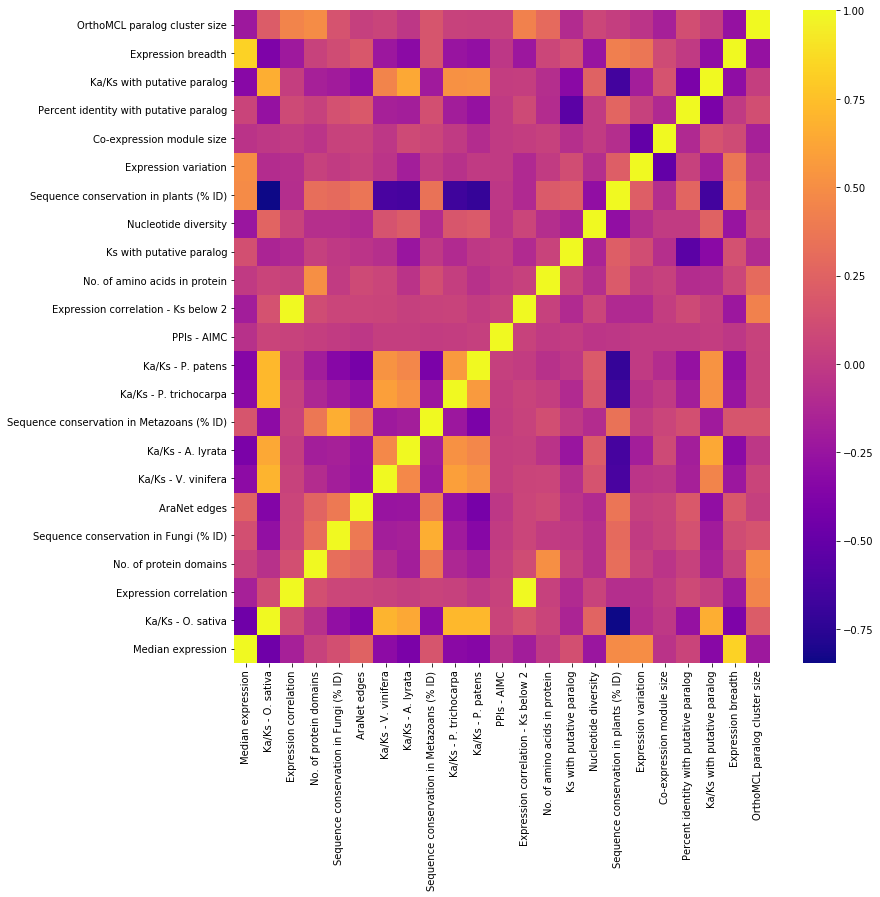

In [19]:
#Redo correlation and plot graph
c2=part2.corr(method="spearman")
plt.figure(figsize=(12,12))
ax = sns.heatmap(c2, cmap="plasma")
ax.invert_yaxis()

Now lets make a boxplot of distributions of Ka/Ks values. I would like to see if these values show an expected trend over phylogenetic distances or whether there is something funky going on. First, we need to extract all columns containing the Ka/Ks string. Normally you would need a for loop/if conditionals etc. to iterate and select out these columns. Pandas can be used to do this fastes.

In [20]:
kaks_cols = [col for col in part2.columns if 'Ka/Ks' in col]
df3 = part2[kaks_cols]
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27206 entries, 0 to 27205
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ka/Ks - O. sativa            5339 non-null   float64
 1   Ka/Ks - V. vinifera          15940 non-null  float64
 2   Ka/Ks - A. lyrata            17180 non-null  float64
 3   Ka/Ks - P. trichocarpa       17807 non-null  float64
 4   Ka/Ks - P. patens            4798 non-null   float64
 5   Ka/Ks with putative paralog  18148 non-null  float64
dtypes: float64(6)
memory usage: 1.2 MB


,Ka/Ks - O. sativa,Ka/Ks - V. vinifera,Ka/Ks - A. lyrata,Ka/Ks - P. trichocarpa,Ka/Ks - P. patens,Ka/Ks with putative paralog
0,NaN,NaN,0.378465,NaN,NaN,0.327199
1,0.345447,0.227884,0.436975,0.154820,0.188989,0.410348
2,NaN,NaN,0.142612,NaN,NaN,0.222570
3,NaN,0.099502,NaN,0.076858,NaN,NaN
4,NaN,NaN,0.000000,0.041979,NaN,0.032641


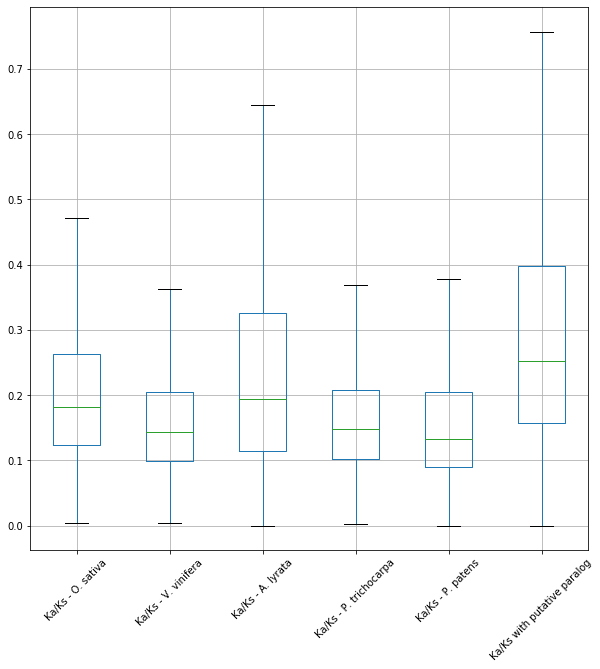

In [21]:
plt.figure(figsize=(10,10))
df3.boxplot(rot=45, showfliers=False)

#What is your interpretation of the following figure? Is this expected or unexpected?

Now lets open the training datasets and see how this distribution looks there

In [22]:
lethal0=open("lethal.tab").readlines()
lethal=[line.strip() for line in lethal0]
nonlethal0=open("nonlethal.tab").readlines()
nonlethal=[line.strip() for line in nonlethal0]
testset0=open("testset.tab").readlines()
testset=[line.strip() for line in testset0]

In [23]:
lethal

['AT1G01040',
 'AT1G01090',
 'AT1G01370',
 'AT1G01550',
 'AT1G02140',
 'AT1G02560',
 'AT1G02580',
 'AT1G02680',
 'AT1G02780',
 'AT1G03190',
 'AT1G03360',
 'AT1G03910',
 'AT1G04635',
 'AT1G04940',
 'AT1G04950',
 'AT1G05190',
 'AT1G05600',
 'AT1G05750',
 'AT1G06150',
 'AT1G06220',
 'AT1G06570',
 'AT1G06950',
 'AT1G07320',
 'AT1G08130',
 'AT1G08190',
 'AT1G08260',
 'AT1G08370',
 'AT1G08510',
 'AT1G08520',
 'AT1G08560',
 'AT1G08660',
 'AT1G08840',
 'AT1G09770',
 'AT1G09820',
 'AT1G10270',
 'AT1G10510',
 'AT1G10840',
 'AT1G10910',
 'AT1G11680',
 'AT1G11755',
 'AT1G11870',
 'AT1G11890',
 'AT1G12260',
 'AT1G12360',
 'AT1G12410',
 'AT1G12770',
 'AT1G13980',
 'AT1G14320',
 'AT1G14610',
 'AT1G14830',
 'AT1G15220',
 'AT1G15510',
 'AT1G16280',
 'AT1G16720',
 'AT1G17220',
 'AT1G17690',
 'AT1G17980',
 'AT1G18370',
 'AT1G19080',
 'AT1G19520',
 'AT1G19800',
 'AT1G19850',
 'AT1G20050',
 'AT1G20200',
 'AT1G20960',
 'AT1G21270',
 'AT1G21310',
 'AT1G21390',
 'AT1G21600',
 'AT1G21650',
 'AT1G21690',
 'AT1G

In [24]:
dfx1 = df2[df2['Locus number'].isin(lethal)]
dfx1_evol = convert_dtype(dfx1[dfx1[kaks_cols].columns[1:24]]).assign(Location="lethal")
dfx1_net = convert_dtype(dfx1[['AraNet edges']]).assign(Location="lethal")
dfx1_pedge = convert_dtype(dfx1[['OrthoMCL paralog cluster size']]).assign(Location="lethal")


dfx2 = df2[df2['Locus number'].isin(nonlethal)]
dfx2_evol = convert_dtype(dfx2[dfx2[kaks_cols].columns[1:24]]).assign(Location="nonlethal")
dfx2_net = convert_dtype(dfx2[['AraNet edges']]).assign(Location="nonlethal")
dfx2_pedge = convert_dtype(dfx2[['OrthoMCL paralog cluster size']]).assign(Location="nonlethal")


dfx3 = df2[df2['Locus number'].isin(testset)]
dfx3_evol = convert_dtype(dfx3[dfx3[kaks_cols].columns[1:24]]).assign(Location="testset")
dfx3_net = convert_dtype(dfx3[['AraNet edges']]).assign(Location="testset")
dfx3_pedge = convert_dtype(dfx3[['OrthoMCL paralog cluster size']]).assign(Location="testset")

#dfx1_evol.head()
dfx1_net.head()

/Users/gauravmoghe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,AraNet edges,Location
3,130.0,lethal
9,15.0,lethal
39,33.0,lethal
59,0.0,lethal
119,172.0,lethal


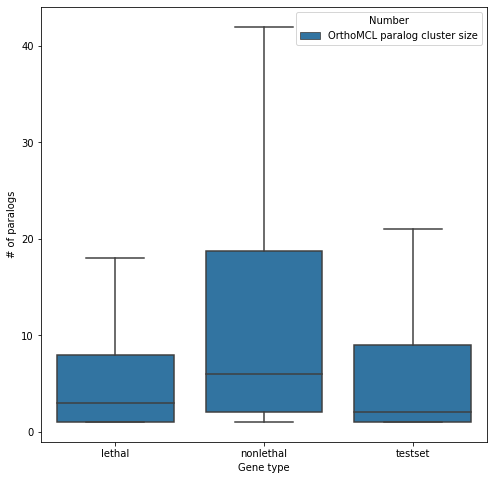

In [27]:
plt.figure(figsize=(8,8))
cdf = pd.concat([dfx1_pedge, dfx2_pedge, dfx3_pedge])    
mdf = pd.melt(cdf, id_vars=['Location'], var_name=['Number'])
#ax = sns.violinplot(x="Location", y="value", hue="Letter", data=mdf)   
ax = sns.boxplot(x="Location", y="value", hue="Number", data=mdf, showfliers=False) 
ax.set(xlabel='Gene type', ylabel='# of paralogs')
#plt.ylim(0, 1)
plt.show()

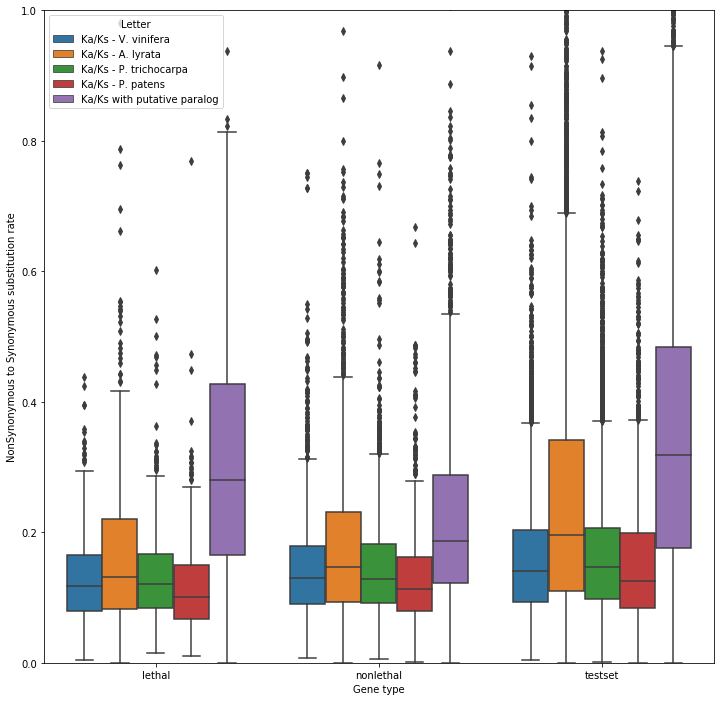

In [28]:
#Concatenate all data frames and make a seaborn boxplot
plt.figure(figsize=(12,12))
cdf = pd.concat([dfx1_evol, dfx2_evol, dfx3_evol])    
mdf = pd.melt(cdf, id_vars=['Location'], var_name=['Letter'])
#ax = sns.violinplot(x="Location", y="value", hue="Letter", data=mdf)   
ax = sns.boxplot(x="Location", y="value", hue="Letter", data=mdf)   
ax.set(xlabel='Gene type', ylabel='NonSynonymous to Synonymous substitution rate')
plt.ylim(0, 1)
plt.show()

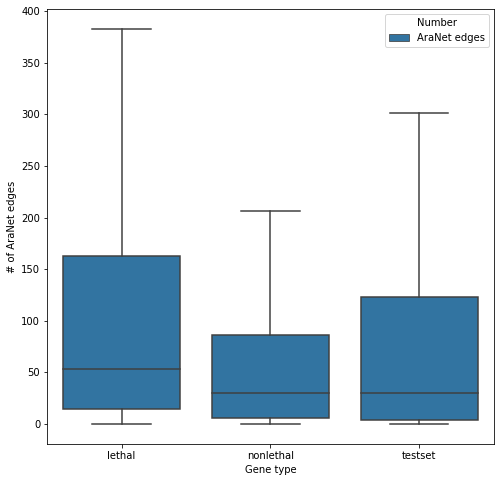

In [29]:
#Concatenate all data frames and make a seaborn boxplot
plt.figure(figsize=(8,8))
cdf = pd.concat([dfx1_net, dfx2_net, dfx3_net])    
mdf = pd.melt(cdf, id_vars=['Location'], var_name=['Number'])
#ax = sns.violinplot(x="Location", y="value", hue="Letter", data=mdf)   
ax = sns.boxplot(x="Location", y="value", hue="Number", data=mdf, showfliers=False)  
ax.set(xlabel='Gene type', ylabel='# of AraNet edges')
#plt.ylim(0, 1)
plt.show()

__What prior hypotheses can you make about which features will be important for classification?__

# Model selection

In [29]:
from pycaret import classification

In [36]:
merge_df = pd.concat([dfx1.assign(mutClass="lethal"), dfx2.assign(mutClass="nonlethal")])    
merge_df.head()

,Locus number,Median expression,Ka/Ks - O. sativa,Expression correlation,No. of protein domains,Sequence conservation in Fungi (% ID),AraNet edges,Ka/Ks - V. vinifera,Ka/Ks - A. lyrata,Sequence conservation in Metazoans (% ID),Ka/Ks - P. trichocarpa,Ka/Ks - P. patens,PPIs - AIMC,Expression correlation - Ks below 2,No. of amino acids in protein,Ks with putative paralog,Nucleotide diversity,Sequence conservation in plants (% ID),Expression variation,Co-expression module size,Percent identity with putative paralog,Ka/Ks with putative paralog,Expression breadth,OrthoMCL paralog cluster size,Core eukaryotic gene,GOslim P cell communication,GOslim P translation,GOslim F lipid binding,GOslim P cell death,GOslim P cell cycle,Pseudogene homolog present,GOslim P metabolic process,GOslim C mitochondrion,beta-gamma WGD paralog retained,Gene body methylated,GOslim P response to biotic stimulus,GOslim C nucleus,GOslim F sequence-specific DNA binding transcription factor activity,GOslim C nucleolus,GOslim P pollination,alpha WGD paralog retained,GOslim P regulation of gene expression epigenetic,GOslim F protein binding,GOslim F kinase activity,GOslim C plastid,GOslim P cellular component organization,GOslim P response to endogenous stimulus,GOslim C extracellular region,Tandem duplicate,No homolog in rice,GOslim C nucleoplasm,GOslim P nucleobase-containing compound metabolic process,GOslim P signal transduction,GOslim F nucleotide binding,GOslim F signal transducer activity,GOslim C plasma membrane,GOslim P response to abiotic stimulus,GOslim P reproduction,mutClass
3,AT1G01040,182.9879852,NaN,0.820561894,9,39.455,130,0.099502488,NaN,44.170,0.076858419,NaN,6,NaN,1910,NaN,0.0006768,74.18,0.274879272,24,41.82,NaN,64,7,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,1,1,0,0,0,0,1,1,lethal
9,AT1G01090,2286.051182,NaN,0.548570615,3,40.090,15,0.073306075,0.039647577,38.920,0.063885042,NaN,2,NaN,428,NaN,0.0016663,85.84,0.205015563,10,40.71,NaN,64,6,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,lethal
39,AT1G01370,19.89916536,NaN,0.966139231,1,53.370,33,0.120361163,0.554441261,60.975,0.158081221,NaN,1,NaN,178,NaN,0.0023395,61.60,0.477392626,14,54.87,NaN,37,14,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,lethal
59,AT1G01550,1440.688191,0.324592973,0.809599547,1,40.270,0,NaN,0.145098039,36.595,NaN,NaN,NaN,0.809599547,349,1.4318,0.0032444,55.96,0.252590985,12,60.81,0.219932952,64,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,lethal
119,AT1G02140,1440.790948,NaN,NaN,1,66.885,172,0.089574899,0.116339869,70.630,0.037741592,NaN,6,NaN,150,NaN,0.0005512,88.08,0.179005914,26,NaN,NaN,64,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,lethal


In [37]:
#Run the following setup command for PyCaret. Last time, we saw that PyCaret had correctly identified the dtypes
#of individual columns. Is it doing so now?

df_setup = classification.setup(data= merge_df, target='mutClass', ignore_features=['Locus number'])

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:43:39
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Models
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Median expression,Categorical
Ka/Ks - O. sativa,Categorical
Expression correlation,Categorical
No. of protein domains,Categorical
Sequence conservation in Fungi (% ID),Numeric
AraNet edges,Categorical
Ka/Ks - V. vinifera,Categorical
Ka/Ks - A. lyrata,Categorical
Sequence conservation in Metazoans (% ID),Numeric
Ka/Ks - P. trichocarpa,Categorical


KeyboardInterrupt: 

In [38]:
#Many continuous data types are being assigned as categorical, which will impact model development
#Fortunately, assigning feature types is a breeze in PyCaret

numFeat = list(merge_df.columns[1:23])
catFeat = list(merge_df.columns[24:58])
df_setup = classification.setup(data= merge_df, target='mutClass', ignore_features=['Locus number'],
                              numeric_features=numFeat, categorical_features=catFeat)

,Description,Value
0,session_id,7228
1,Target,mutClass
2,Target Type,Binary
3,Label Encoded,"lethal: 0, nonlethal: 1"
4,Original Data,"(3443, 59)"
5,Missing Values,True
6,Numeric Features,23
7,Categorical Features,34
8,Ordinal Features,False
9,High Cardinality Features,False


In [39]:
df_setup[0]

-1

In [40]:
classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8191,0.7888,0.9698,0.8315,0.8953,0.2583,0.3079,8.8440
gbc,Gradient Boosting Classifier,0.8178,0.7878,0.9656,0.8326,0.8942,0.2643,0.3088,0.5340
et,Extra Trees Classifier,0.8170,0.7776,0.9734,0.8275,0.8945,0.2357,0.2923,0.4170
rf,Random Forest Classifier,0.8166,0.7871,0.9807,0.8232,0.8950,0.2106,0.2791,0.5110
xgboost,Extreme Gradient Boosting,0.8154,0.7782,0.9443,0.8430,0.8907,0.3067,0.3300,1.6370
lda,Linear Discriminant Analysis,0.8141,0.7723,0.9516,0.8375,0.8908,0.2812,0.3116,0.0250
lr,Logistic Regression,0.8133,0.7745,0.9578,0.8331,0.8910,0.2591,0.2979,0.9880
ridge,Ridge Classifier,0.8133,0.0000,0.9755,0.8231,0.8928,0.2065,0.2658,0.0190
lightgbm,Light Gradient Boosting Machine,0.8120,0.7791,0.9464,0.8388,0.8892,0.2819,0.3080,0.1690
ada,Ada Boost Classifier,0.8041,0.7624,0.9297,0.8413,0.8832,0.2840,0.2996,0.1790


__When I ran it catboost was the best classifier. Is it still so? Would you choose it as your classifier of choice? Why? Why not?__

What you did above was you searched across default parameters of multiple models to find out the best ones. Once you select a model of your liking, you need to build your model and then explore the hyperparameter space of that model to find the best set of parameters for classification.

In [34]:
#Using gradient boosting 
df_gbc = classification.create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7925,0.7467,0.9424,0.8219,0.8780,0.2047,0.2287
1,0.7925,0.7824,0.9319,0.8279,0.8768,0.2333,0.2509
2,0.8050,0.7584,0.9634,0.8214,0.8867,0.2160,0.2587
3,0.8340,0.8536,0.9792,0.8393,0.9038,0.3230,0.3843
4,0.8133,0.7943,0.9427,0.8419,0.8894,0.3015,0.3228
5,0.8008,0.8010,0.9479,0.8273,0.8835,0.2190,0.2460
6,0.8257,0.7806,0.9740,0.8348,0.8990,0.2892,0.3440
7,0.8133,0.7800,0.9531,0.8356,0.8905,0.2748,0.3052
8,0.8257,0.7963,0.9688,0.8378,0.8986,0.3032,0.3496
9,0.7967,0.7654,0.9583,0.8178,0.8825,0.1623,0.1966


In [35]:
#Tune model by searching hyperparameter space
tuned_gbc = classification.tune_model(df_gbc, n_iter=5, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7884,0.7668,0.9529,0.8125,0.8771,0.1492,0.1788
1,0.8340,0.8222,0.9738,0.8416,0.9029,0.3517,0.4025
2,0.8174,0.7391,0.9895,0.8182,0.8957,0.2122,0.3040
3,0.8216,0.8431,0.9740,0.8311,0.8969,0.2649,0.3208
4,0.8174,0.8237,0.9479,0.8426,0.8922,0.3107,0.3353
5,0.8050,0.8334,0.9531,0.8281,0.8862,0.2278,0.2591
6,0.7967,0.7665,0.9740,0.8095,0.8842,0.1080,0.1534
7,0.8216,0.7773,0.9792,0.8282,0.8974,0.2497,0.3153
8,0.8008,0.8341,0.9583,0.8214,0.8846,0.1876,0.2232
9,0.7884,0.7210,0.9583,0.8106,0.8783,0.1101,0.1390


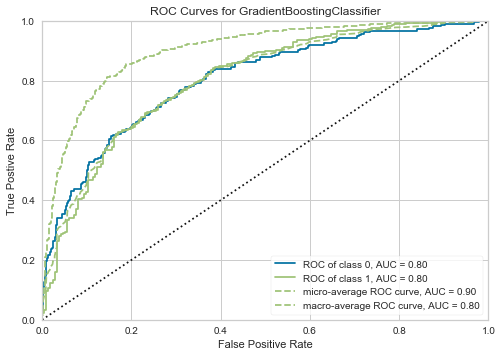

In [36]:
#Look at the AUROC curve
classification.plot_model(tuned_gbc, plot = 'auc')

In [37]:
classification.evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

__Are you satisfied with this performance? Why? Why not?__

Let us now find out which features enabled classification the most?

# Finding important features and making predictions

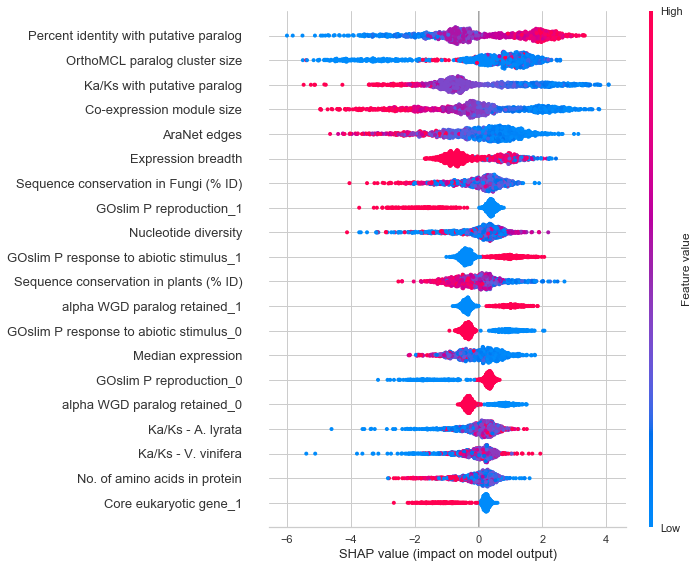

In [38]:
classification.interpret_model(tuned_gbc)

#Do you see anything interesting in the top informative features?

In [39]:
dfx3.head()

,Locus number,Median expression,Ka/Ks - O. sativa,Expression correlation,No. of protein domains,Sequence conservation in Fungi (% ID),AraNet edges,Ka/Ks - V. vinifera,Ka/Ks - A. lyrata,Sequence conservation in Metazoans (% ID),...,Tandem duplicate,No homolog in rice,GOslim C nucleoplasm,GOslim P nucleobase-containing compound metabolic process,GOslim P signal transduction,GOslim F nucleotide binding,GOslim F signal transducer activity,GOslim C plasma membrane,GOslim P response to abiotic stimulus,GOslim P reproduction
4,AT1G01050,1093.078484,NaN,0.528097411,1,38.810,3,NaN,0,35.775,...,0,0,0,1,0,0,0,0,0,0
7,AT1G01073,NaN,NaN,NaN,0,0.000,NaN,NaN,NaN,0.000,...,0,1,0,0,0,0,0,0,0,0
8,AT1G01080,326.1262958,NaN,0.961121465,3,44.625,60,0.144675812,NaN,42.970,...,0,0,0,0,0,0,0,0,0,0
10,AT1G01100,9797.744032,NaN,0.882259291,1,68.690,532,NaN,NaN,51.640,...,0,1,0,0,0,0,0,1,0,0
12,AT1G01115,NaN,NaN,NaN,0,0.000,NaN,NaN,NaN,0.000,...,0,1,0,0,0,0,0,0,0,0


In [40]:
#Lets make some predictions on the test set (30% of the set kept out of the training process - holdout set)
#Pycaret can automatically pull out this holdout set from the setup function you performed before
predictions = classification.predict_model(tuned_gbc)
predictions

#Check the last three columns

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8287,0.8035,0.9756,0.8361,0.9005,0.3092,0.3659


,Median expression,Ka/Ks - O. sativa,Expression correlation,No. of protein domains,Sequence conservation in Fungi (% ID),AraNet edges,Ka/Ks - V. vinifera,Ka/Ks - A. lyrata,Sequence conservation in Metazoans (% ID),Ka/Ks - P. trichocarpa,...,GOslim F signal transducer activity_1,GOslim C plasma membrane_0,GOslim C plasma membrane_1,GOslim P response to abiotic stimulus_0,GOslim P response to abiotic stimulus_1,GOslim P reproduction_0,GOslim P reproduction_1,mutClass,Label,Score
0,6.096778,0.159316,0.567311,1.0,37.840,87.540065,0.130128,0.131808,26.285,0.167759,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,lethal,nonlethal,1.000
1,539.237338,0.174576,0.567311,2.0,90.240,721.000000,0.232927,0.179868,97.560,0.023867,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,nonlethal,nonlethal,1.000
2,539.237338,0.140282,0.567311,2.0,38.520,46.000000,0.127010,0.256119,37.010,0.115487,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,nonlethal,nonlethal,1.000
3,11.206010,0.228553,0.580249,1.0,29.590,87.540065,0.207173,0.164151,16.465,0.181839,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,nonlethal,nonlethal,1.000
4,539.237338,0.738567,0.567311,7.0,50.000,99.000000,0.295074,0.179868,48.285,0.343199,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,nonlethal,nonlethal,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,5.635958,0.174576,0.557596,1.0,38.100,12.000000,0.141071,0.179868,35.780,0.144245,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,lethal,nonlethal,1.000
1029,356.290319,0.174576,0.813813,1.0,55.210,151.000000,0.041098,0.000000,62.500,0.038778,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,nonlethal,nonlethal,1.000
1030,222.528730,0.174576,0.926688,1.0,40.000,12.000000,0.052566,0.105923,37.940,0.077880,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,nonlethal,nonlethal,1.000
1031,368.453138,0.174576,0.846836,2.0,50.000,1.000000,0.069911,0.205644,47.990,0.109821,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,nonlethal,nonlethal,1.000


In [41]:
final_model = classification.finalize_model(tuned_gbc)

In [42]:
dfx3 = dfx3.assign(mutClass='test')
unseen_pred = classification.predict_model(final_model, data=dfx3)

In [ ]:
unseen_pred.to_csv('finalout.tab', sep="\t")

There you go. Check the output file. The End!